
# UA NS5 Aux Channel Plotter

This notebook loads a UA bundle (`*_UA_bundle.npz`) and plots the NS5 aux channels, if present:

- `camera_sync` (expected `ch134`)
- `triangle_sync` (expected `ch138`)

### How to use
1. Set `BUNDLES_DIR` to your UA bundles folder (usually something like `.../results/bundles/UA`).
2. Run the search cell to list found bundles.
3. If multiple are found, set `IDX` to the entry you want and re-run the loader/plot cells.
4. Optionally adjust `START_SEC` / `END_SEC` to zoom.


In [9]:

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import RCP_analysis as rcp

/home/bryan/miniconda3/envs/pipeline/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:

# ---- Set this to your UA bundles directory ----
BUNDLES_DIR = Path("/home/bryan/mnt/cullen/Current Project Databases - NHP/2025 Cerebellum prosthesis/Nike/NRR_RW003_check/results/bundles")   # e.g., /path/to/OUT_BASE/bundles/UA

# If you didn't set it, default to current directory
if "<<" in str(BUNDLES_DIR):
    print("[note] BUNDLES_DIR not set; defaulting to current working directory")
    BUNDLES_DIR = Path.cwd()

# Find UA bundles
cands = sorted(BUNDLES_DIR.rglob("*_UA_bundle.npz"))
print(f"Found {len(cands)} UA bundle(s) under: {BUNDLES_DIR}")
for i, p in enumerate(cands[:50]):
    print(f"{i:02d}: {p}")

# Pick which one to open (0 by default)
IDX = 0
NPZ_PATH = cands[IDX] if cands else None
NPZ_PATH


Found 1 UA bundle(s) under: /home/bryan/mnt/cullen/Current Project Databases - NHP/2025 Cerebellum prosthesis/Nike/NRR_RW003_check/results/bundles
00: /home/bryan/mnt/cullen/Current Project Databases - NHP/2025 Cerebellum prosthesis/Nike/NRR_RW003_check/results/bundles/UA/NRR_RW_003_001_UA_bundle.npz


PosixPath('/home/bryan/mnt/cullen/Current Project Databases - NHP/2025 Cerebellum prosthesis/Nike/NRR_RW003_check/results/bundles/UA/NRR_RW_003_001_UA_bundle.npz')

In [11]:

def load_aux(npz_path: Path):
    if npz_path is None:
        raise FileNotFoundError("No UA bundle selected (NPZ_PATH is None).")
    with np.load(npz_path, allow_pickle=False) as z:
        fs = float(z.get("aux_fs", np.nan))
        # Pull aux signals if present
        aux = {}
        for key in ("camera_sync", "triangle_sync"):
            aux[key] = z[key] if key in z else None
    return fs, aux

fs, aux = load_aux(NPZ_PATH)
print("Sampling rate (NS5 aux):", fs, "Hz")
print({k: (None if aux[k] is None else aux[k].shape) for k in aux})


Sampling rate (NS5 aux): 30000.0 Hz
{'camera_sync': (2891446,), 'triangle_sync': (2891446,)}


In [12]:
def plot_signal(sig, fs, title, channel=None, start=None, end=None, max_points=200_000):
    if sig is None:
        print(f"[skip] {title}: not in bundle")
        return

    n = sig.size
    t = np.arange(n, dtype=np.float64) / float(fs if fs else 1.0)

    # Crop to window
    if start is not None or end is not None:
        t0 = 0.0 if start is None else float(start)
        t1 = t[-1] if end is None else float(end)
        mask = (t >= t0) & (t <= t1)
        t = t[mask]
        sig = sig[mask]

    # Light decimation for large arrays
    step = max(1, int(np.ceil(sig.size / max_points)))
    if step > 1:
        t = t[::step]
        sig = sig[::step]

    # Build title suffix from channel
    ch_suffix = ""
    if channel is not None:
        try:
            ch_num = int(channel) if float(channel).is_integer() else float(channel)
            ch_suffix = f" (ch{ch_num})"
        except Exception:
            ch_suffix = f" ({channel})"

    plt.figure()
    plt.plot(t, sig)  # no explicit colors
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (a.u.)")
    plt.title(f"{title}{ch_suffix}")
    plt.tight_layout()


In [14]:
# Optional zoom window (in seconds). Set to None for full duration.
START_SEC = None
END_SEC   = None

REPO_ROOT = Path().resolve().parents[0]
PARAMS    = rcp.load_experiment_params(REPO_ROOT / "config" / "params.yaml", repo_root=REPO_ROOT)

# Sync channels
PROBE_CFG = (PARAMS.probes or {}).get("UA", {})
CAMERA_SYNC_CH = float(PROBE_CFG.get("camera_sync_ch", 134))
TRIANGLE_SYNC_CH = float(PROBE_CFG.get("triangle_sync_ch", 138.0))

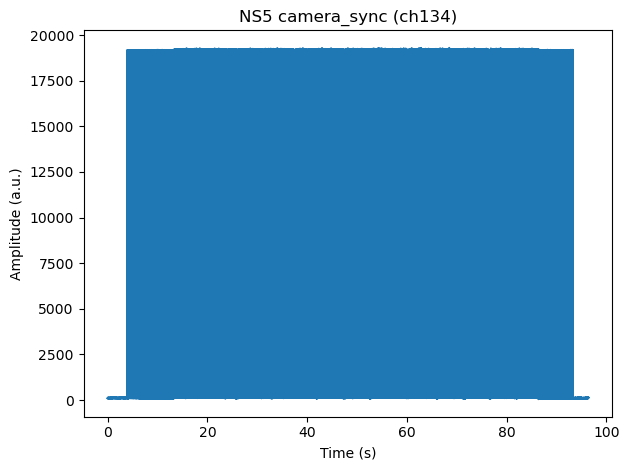

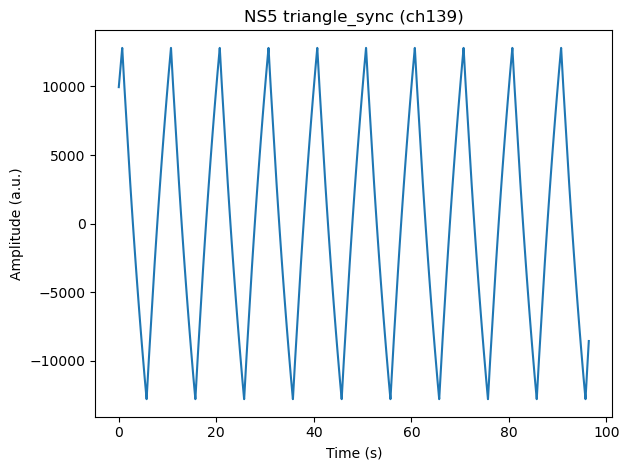

In [15]:

plot_signal(aux.get("camera_sync"),  fs, "NS5 camera_sync", CAMERA_SYNC_CH,  START_SEC, END_SEC)
plot_signal(aux.get("triangle_sync"),fs, "NS5 triangle_sync (ch139)",START_SEC, END_SEC)
